**Capítulo 10 - Introdução às redes neurais artificiais com Keras**

_Este notebook contém todo o código de amostra e soluções para os exercícios no capítulo 10._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml3/blob/main/10_neural_nets_with_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml3/blob/main/10_neural_nets_with_keras.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

Este projeto requer Python 3.7 ou acima:

In [1]:
import sys

assert sys.version_info >= (3, 7)

Também requer Scikit-Learn ≥ 1.0.1:

In [2]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

E tensorflow ≥ 2,8:

In [3]:
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

2024-01-18 19:28:49.102503: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-18 19:28:54.670430: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cudnn/lib64:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/lib64:/usr/local/cudnn/lib64:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/lib64:/usr/local/cudnn/lib64:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/lib64:/usr/local/cudnn/lib64:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/lib64:/usr/local/cuda-12/lib64:/usr/local/cudnn/lib64:/usr/local/cuda/extras/CUPTI/lib64:/usr/lo

Como fizemos nos capítulos anteriores, vamos definir os tamanhos de fonte padrão para tornar as figuras mais bonitas:

In [4]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

E vamos criar a pasta `images/ann` (se ainda não existir) e definir a função` save_fig () `que é usada através deste notebook para salvar as figuras em alta resolução para o livro:

In [5]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "ann"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Dos neurônios biológicos a artificiais
## O perceptron

In [6]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = (iris.target == 0)  # Iris setosa

per_clf = Perceptron(random_state=42)
per_clf.fit(X, y)

X_new = [[2, 0.5], [3, 1]]
y_pred = per_clf.predict(X_new)  # predicts True and False for these 2 flowers

In [7]:
y_pred

array([ True, False])

O `perceptron` é equivalente a um` sgdclassifier` com `perda =" perceptron "`, sem regularização e uma taxa de aprendizado constante igual a 1:

In [8]:
# extra code – shows how to build and train a Perceptron

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss="perceptron", penalty=None,
                        learning_rate="constant", eta0=1, random_state=42)
sgd_clf.fit(X, y)
assert (sgd_clf.coef_ == per_clf.coef_).all()
assert (sgd_clf.intercept_ == per_clf.intercept_).all()

Quando o perceptron encontra um limite de decisão que separa corretamente as classes, ele para de aprender.Isso significa que o limite de decisão geralmente é bastante próximo de uma classe:

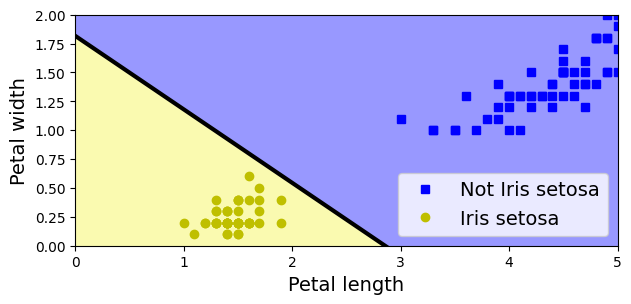

In [9]:
# extra code – plots the decision boundary of a Perceptron on the iris dataset

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

a = -per_clf.coef_[0, 0] / per_clf.coef_[0, 1]
b = -per_clf.intercept_ / per_clf.coef_[0, 1]
axes = [0, 5, 0, 2]
x0, x1 = np.meshgrid(
    np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
    np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
)
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.figure(figsize=(7, 3))
plt.plot(X[y == 0, 0], X[y == 0, 1], "bs", label="Not Iris setosa")
plt.plot(X[y == 1, 0], X[y == 1, 1], "yo", label="Iris setosa")
plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-",
         linewidth=3)
plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="lower right")
plt.axis(axes)
plt.show()

**Funções de ativação**

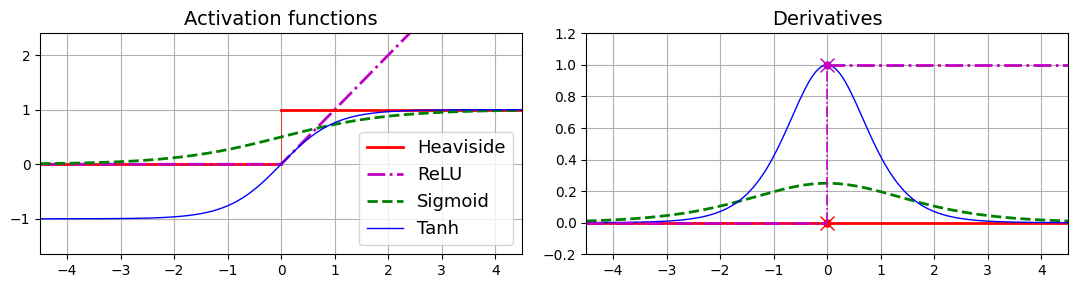

In [10]:
# extra code – this cell generates and saves Figure 10–8

from scipy.special import expit as sigmoid

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

max_z = 4.5
z = np.linspace(-max_z, max_z, 200)

plt.figure(figsize=(11, 3.1))

plt.subplot(121)
plt.plot([-max_z, 0], [0, 0], "r-", linewidth=2, label="Heaviside")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.plot([0, 0], [0, 1], "r-", linewidth=0.5)
plt.plot([0, max_z], [1, 1], "r-", linewidth=2)
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=1, label="Tanh")
plt.grid(True)
plt.title("Activation functions")
plt.axis([-max_z, max_z, -1.65, 2.4])
plt.gca().set_yticks([-1, 0, 1, 2])
plt.legend(loc="lower right", fontsize=13)

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=2, label="Heaviside")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=1, label="Tanh")
plt.plot([-max_z, 0], [0, 0], "m-.", linewidth=2)
plt.plot([0, max_z], [1, 1], "m-.", linewidth=2)
plt.plot([0, 0], [0, 1], "m-.", linewidth=1.2)
plt.plot(0, 1, "mo", markersize=5)
plt.plot(0, 1, "mx", markersize=10)
plt.grid(True)
plt.title("Derivatives")
plt.axis([-max_z, max_z, -0.2, 1.2])

save_fig("activation_functions_plot")
plt.show()

## Regressão MLPS

In [11]:
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

mlp_reg = MLPRegressor(hidden_layer_sizes=[50, 50, 50], random_state=42)
pipeline = make_pipeline(StandardScaler(), mlp_reg)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_valid)
rmse = mean_squared_error(y_valid, y_pred, squared=False)

In [12]:
rmse

0.5053326657968448

## Classificação MLPs

In [13]:
# extra code – this was left as an exercise for the reader

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

iris = load_iris()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    iris.data, iris.target, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.1, random_state=42)

mlp_clf = MLPClassifier(hidden_layer_sizes=[5], max_iter=10_000,
                        random_state=42)
pipeline = make_pipeline(StandardScaler(), mlp_clf)
pipeline.fit(X_train, y_train)
accuracy = pipeline.score(X_valid, y_valid)
accuracy

1.0

# Implementando MLPs com Keras
## Construindo um classificador de imagem usando a API seqüencial
### usando keras para carregar o conjunto de dados

Vamos começar carregando o conjunto de dados MNIST da moda.Keras possui várias funções para carregar conjuntos de dados populares em `tf.keras.datasets`.O conjunto de dados já está dividido para você entre um conjunto de treinamento (60.000 imagens) e um conjunto de testes (10.000 imagens), mas pode ser útil dividir ainda mais o conjunto de treinamento para ter um conjunto de validação.Usaremos 55.000 imagens para treinamento e 5.000 para validação.

In [14]:
import tensorflow as tf

fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

4422102/4422102 [==============================] - 0s 0us/step


O conjunto de treinamento contém 60.000 imagens em escala de cinza, cada um 28x28 pixels:

In [15]:
X_train.shape

(55000, 28, 28)

Cada intensidade do pixel é representada como um byte (0 a 255):

In [16]:
X_train.dtype

dtype('uint8')

Vamos escalar as intensidades de pixel até a faixa de 0-1 e convertê-las em flutuadores, dividindo-se por 255:

In [17]:
X_train, X_valid, X_test = X_train / 255., X_valid / 255., X_test / 255.

Você pode plotar uma imagem usando a função `imshow()`, com um `'binary'`
 mapa de cores:

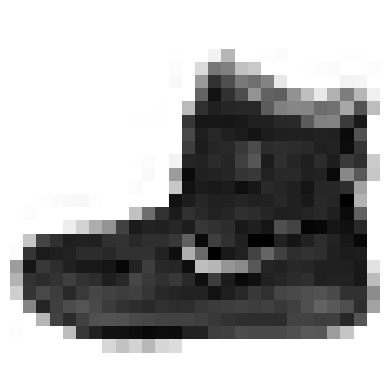

In [18]:
# extra code

plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

Os rótulos são os IDs de classe (representados como UINT8), de 0 a 9:

In [19]:
y_train

array([9, 0, 0, ..., 9, 0, 2], dtype=uint8)

Aqui estão os nomes de classe correspondentes:

In [20]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

Portanto, a primeira imagem no conjunto de treinamento é uma bota no tornozelo:

In [21]:
class_names[y_train[0]]

'Ankle boot'

Vamos dar uma olhada em uma amostra das imagens no conjunto de dados:

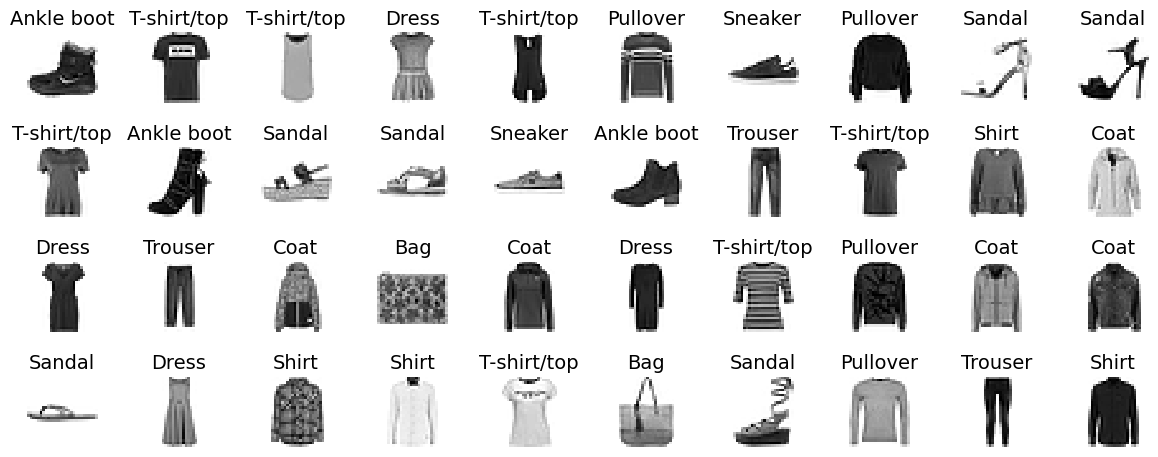

In [22]:
# extra code – this cell generates and saves Figure 10–10

n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]])
plt.subplots_adjust(wspace=0.2, hspace=0.5)

save_fig("fashion_mnist_plot")
plt.show()

### Criando o modelo usando a API seqüencial

In [23]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=[28, 28]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(300, activation="relu"))
model.add(tf.keras.layers.Dense(100, activation="relu"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

2024-01-18 19:30:53.093806: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-01-18 19:30:53.093862: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (dayvson): /proc/driver/nvidia/version does not exist
2024-01-18 19:30:53.098296: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [24]:
# extra code – clear the session to reset the name counters
tf.keras.backend.clear_session()
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


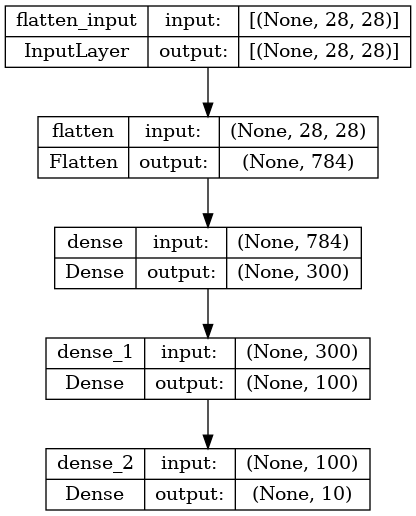

In [26]:
# extra code – another way to display the model's architecture
tf.keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

In [27]:
model.layers

In [28]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [29]:
model.get_layer('dense') is hidden1

True

In [30]:
weights, biases = hidden1.get_weights()
weights

array([[ 0.03640077,  0.05351375,  0.0475008 , ...,  0.02987488,
         0.02597682, -0.05292917],
       [ 0.04573371, -0.04544484,  0.04541981, ...,  0.00558751,
        -0.03617882, -0.02609288],
       [-0.01702479,  0.03576501, -0.0204714 , ...,  0.04278874,
         0.03657717,  0.04365089],
       ...,
       [ 0.00439613, -0.04089494,  0.06004365, ...,  0.06964153,
        -0.01552076,  0.04892201],
       [ 0.02143387,  0.05344976, -0.04100364, ...,  0.06829962,
         0.00709143,  0.03951229],
       [ 0.01155779,  0.04848827, -0.06194749, ...,  0.00279243,
        -0.05045281,  0.02076955]], dtype=float32)

In [31]:
weights.shape

(784, 300)

In [32]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [33]:
biases.shape

(300,)

### Compilando o modelo

In [34]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

Isso é equivalente a:

In [35]:
# extra code – this cell is equivalent to the previous cell
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.SGD(),
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])

In [36]:
# extra code – shows how to convert class ids to one-hot vectors
tf.keras.utils.to_categorical([0, 5, 1, 0], num_classes=10)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

Nota: É importante definir `num_classes` quando o número de classes é maior que o ID máximo de classe na amostra.

In [37]:
# extra code – shows how to convert one-hot vectors to class ids
np.argmax(
    [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
     [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
     [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
     [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
    axis=1
)

array([0, 5, 1, 0])

### Treinando e avaliando o modelo

In [38]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

2024-01-18 19:30:54.733078: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 172480000 exceeds 10% of free system memory.


Epoch 1/30
1719/1719 [==============================] - 7s 3ms/step - loss: 0.7182 - sparse_categorical_accuracy: 0.7619 - val_loss: 0.5161 - val_sparse_categorical_accuracy: 0.8158
Epoch 2/30
1719/1719 [==============================] - 4s 3ms/step - loss: 0.4908 - sparse_categorical_accuracy: 0.8285 - val_loss: 0.4668 - val_sparse_categorical_accuracy: 0.8298
Epoch 3/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4436 - sparse_categorical_accuracy: 0.8438 - val_loss: 0.4262 - val_sparse_categorical_accuracy: 0.8508
Epoch 4/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4175 - sparse_categorical_accuracy: 0.8534 - val_loss: 0.3983 - val_sparse_categorical_accuracy: 0.8572
Epoch 5/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3958 - sparse_categorical_accuracy: 0.8611 - val_loss: 0.3911 - val_sparse_categorical_accuracy: 0.8608
Epoch 6/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3790 - spars

In [39]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 1719}

In [40]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


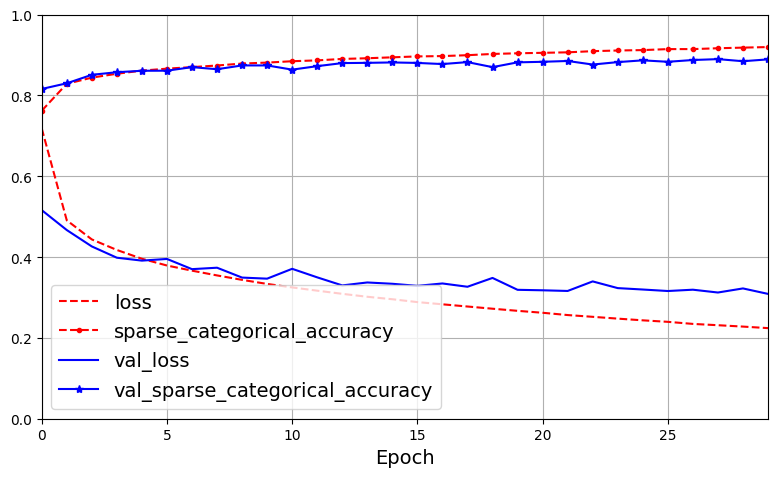

In [41]:
import matplotlib.pyplot as plt
import pandas as pd

pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, 29], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.legend(loc="lower left")  # extra code
save_fig("keras_learning_curves_plot")  # extra code
plt.show()

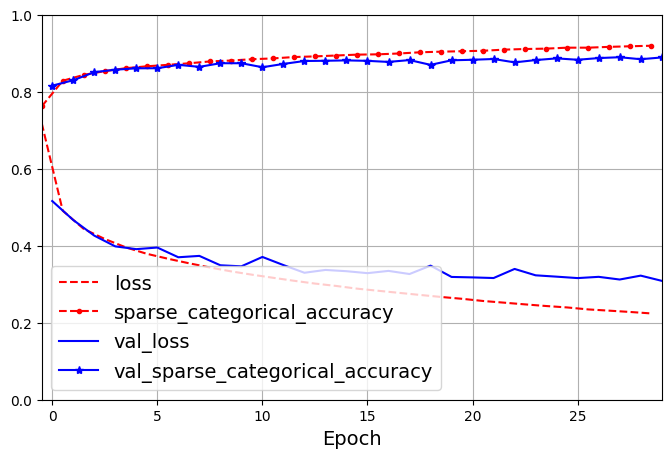

In [42]:
# extra code – shows how to shift the training curve by -1/2 epoch
plt.figure(figsize=(8, 5))
for key, style in zip(history.history, ["r--", "r--.", "b-", "b-*"]):
    epochs = np.array(history.epoch) + (0 if key.startswith("val_") else -0.5)
    plt.plot(epochs, history.history[key], style, label=key)
plt.xlabel("Epoch")
plt.axis([-0.5, 29, 0., 1])
plt.legend(loc="lower left")
plt.grid()
plt.show()

In [43]:
model.evaluate(X_test, y_test)

 65/313 [=====>........................] - ETA: 0s - loss: 0.3154 - sparse_categorical_accuracy: 0.8870

2024-01-18 19:33:20.380748: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 31360000 exceeds 10% of free system memory.


313/313 [==============================] - 1s 2ms/step - loss: 0.3237 - sparse_categorical_accuracy: 0.8854


[0.3236737549304962, 0.8853999972343445]

### Usando o modelo para fazer previsões

In [44]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 [==============================] - 0s 98ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.01, 0.  , 0.97],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [45]:
y_pred = y_proba.argmax(axis=-1)
y_pred

array([9, 2, 1])

In [46]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [47]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

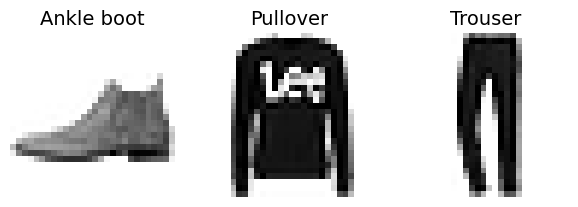

In [48]:
# extra code – this cell generates and saves Figure 10–12
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

## Construindo um MLP de regressão usando a API sequencial

Vamos carregar, dividir e escalar o conjunto de dados da California Housing (o original, não o modificado como no capítulo 2):

In [49]:
# extra code – load and split the California housing dataset, like earlier
housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

In [50]:
tf.random.set_seed(42)
norm_layer = tf.keras.layers.Normalization(input_shape=X_train.shape[1:])
model = tf.keras.Sequential([
    norm_layer,
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(1)
])
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
norm_layer.adapt(X_train)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test, rmse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 0.9241 - root_mean_squared_error: 0.9613 - val_loss: 0.5071 - val_root_mean_squared_error: 0.7121
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3815 - root_mean_squared_error: 0.6177 - val_loss: 1.0458 - val_root_mean_squared_error: 1.0227
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3645 - root_mean_squared_error: 0.6038 - val_loss: 0.4667 - val_root_mean_squared_error: 0.6832
Epoch 4/20
363/363 [==============================] - 1s 3ms/step - loss: 0.3477 - root_mean_squared_error: 0.5897 - val_loss: 0.8464 - val_root_mean_squared_error: 0.9200
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3319 - root_mean_squared_error: 0.5761 - val_loss: 0.4966 - val_root_mean_squared_error: 0.7047
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3324 - root_mean_squared_error: 0.5765 - val_loss: 0.8457 - val_

In [51]:
rmse_test

0.5313032865524292

In [52]:
y_pred

array([[0.5054533],
       [1.1683892],
       [4.7756925]], dtype=float32)

## Construindo modelos complexos usando a API funcional

Nem todos os modelos de rede neural são simplesmente sequenciais.Alguns podem ter topologias complexas.Alguns podem ter várias entradas e/ou várias saídas.Por exemplo, uma rede neural ampla e profunda (consulte [Paper](https://ai.google/research/pubs/pub45413)) conecta tudo ou parte das entradas diretamente à camada de saída.

In [53]:
# extra code – reset the name counters and make the code reproducible
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [54]:
normalization_layer = tf.keras.layers.Normalization()
hidden_layer1 = tf.keras.layers.Dense(30, activation="relu")
hidden_layer2 = tf.keras.layers.Dense(30, activation="relu")
concat_layer = tf.keras.layers.Concatenate()
output_layer = tf.keras.layers.Dense(1)

input_ = tf.keras.layers.Input(shape=X_train.shape[1:])
normalized = normalization_layer(input_)
hidden1 = hidden_layer1(normalized)
hidden2 = hidden_layer2(hidden1)
concat = concat_layer([normalized, hidden2])
output = output_layer(concat)

model = tf.keras.Model(inputs=[input_], outputs=[output])

In [55]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 normalization (Normalization)  (None, 8)            17          ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 30)           270         ['normalization[0][0]']          
                                                                                                  
 dense_1 (Dense)                (None, 30)           930         ['dense[0][0]']                  
                                                                                              

In [56]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
normalization_layer.adapt(X_train)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 1.1140 - root_mean_squared_error: 1.0555 - val_loss: 1.0148 - val_root_mean_squared_error: 1.0074
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4310 - root_mean_squared_error: 0.6565 - val_loss: 0.7355 - val_root_mean_squared_error: 0.8576
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3886 - root_mean_squared_error: 0.6234 - val_loss: 0.5290 - val_root_mean_squared_error: 0.7273
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3711 - root_mean_squared_error: 0.6092 - val_loss: 0.3690 - val_root_mean_squared_error: 0.6075
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3601 - root_mean_squared_error: 0.6001 - val_loss: 0.3474 - val_root_mean_squared_error: 0.5894
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3490 - root_mean_squared_error: 0.5907 - val_loss: 0.8513 - val_

E se você quiser enviar diferentes subconjuntos de recursos de entrada através dos caminhos amplos ou profundos?Enviaremos 5 recursos (recursos de 0 a 4) e 6 através do caminho profundo (apresenta 2 a 7).Observe que 3 recursos passarão por ambos (recursos 2, 3 e 4).

In [57]:
tf.random.set_seed(42)  # extra code

In [58]:
input_wide = tf.keras.layers.Input(shape=[5])  # features 0 to 4
input_deep = tf.keras.layers.Input(shape=[6])  # features 2 to 7
norm_layer_wide = tf.keras.layers.Normalization()
norm_layer_deep = tf.keras.layers.Normalization()
norm_wide = norm_layer_wide(input_wide)
norm_deep = norm_layer_deep(input_deep)
hidden1 = tf.keras.layers.Dense(30, activation="relu")(norm_deep)
hidden2 = tf.keras.layers.Dense(30, activation="relu")(hidden1)
concat = tf.keras.layers.concatenate([norm_wide, hidden2])
output = tf.keras.layers.Dense(1)(concat)
model = tf.keras.Model(inputs=[input_wide, input_deep], outputs=[output])

In [59]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])

X_train_wide, X_train_deep = X_train[:, :5], X_train[:, 2:]
X_valid_wide, X_valid_deep = X_valid[:, :5], X_valid[:, 2:]
X_test_wide, X_test_deep = X_test[:, :5], X_test[:, 2:]
X_new_wide, X_new_deep = X_test_wide[:3], X_test_deep[:3]

norm_layer_wide.adapt(X_train_wide)
norm_layer_deep.adapt(X_train_deep)
history = model.fit((X_train_wide, X_train_deep), y_train, epochs=20,
                    validation_data=((X_valid_wide, X_valid_deep), y_valid))
mse_test = model.evaluate((X_test_wide, X_test_deep), y_test)
y_pred = model.predict((X_new_wide, X_new_deep))

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 2.0144 - root_mean_squared_error: 1.4193 - val_loss: 0.7132 - val_root_mean_squared_error: 0.8445
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6201 - root_mean_squared_error: 0.7875 - val_loss: 0.9793 - val_root_mean_squared_error: 0.9896
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5061 - root_mean_squared_error: 0.7114 - val_loss: 0.4642 - val_root_mean_squared_error: 0.6813
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4381 - root_mean_squared_error: 0.6619 - val_loss: 0.4784 - val_root_mean_squared_error: 0.6916
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3930 - root_mean_squared_error: 0.6269 - val_loss: 0.3763 - val_root_mean_squared_error: 0.6134
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3692 - root_mean_squared_error: 0.6076 - val_loss: 0.3432 - val_

Adicionando uma saída auxiliar para regularização:

In [60]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [61]:
input_wide = tf.keras.layers.Input(shape=[5])  # features 0 to 4
input_deep = tf.keras.layers.Input(shape=[6])  # features 2 to 7
norm_layer_wide = tf.keras.layers.Normalization()
norm_layer_deep = tf.keras.layers.Normalization()
norm_wide = norm_layer_wide(input_wide)
norm_deep = norm_layer_deep(input_deep)
hidden1 = tf.keras.layers.Dense(30, activation="relu")(norm_deep)
hidden2 = tf.keras.layers.Dense(30, activation="relu")(hidden1)
concat = tf.keras.layers.concatenate([norm_wide, hidden2])
output = tf.keras.layers.Dense(1)(concat)
aux_output = tf.keras.layers.Dense(1)(hidden2)
model = tf.keras.Model(inputs=[input_wide, input_deep],
                       outputs=[output, aux_output])

In [62]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss=("mse", "mse"), loss_weights=(0.9, 0.1), optimizer=optimizer,
              metrics=["RootMeanSquaredError"])

In [63]:
norm_layer_wide.adapt(X_train_wide)
norm_layer_deep.adapt(X_train_deep)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=20,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid))
)

Epoch 1/20
363/363 [==============================] - 2s 2ms/step - loss: 1.3844 - dense_2_loss: 1.3124 - dense_3_loss: 2.0322 - dense_2_root_mean_squared_error: 1.1456 - dense_3_root_mean_squared_error: 1.4256 - val_loss: 1.7212 - val_dense_2_loss: 1.6412 - val_dense_3_loss: 2.4410 - val_dense_2_root_mean_squared_error: 1.2811 - val_dense_3_root_mean_squared_error: 1.5624
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5209 - dense_2_loss: 0.4887 - dense_3_loss: 0.8109 - dense_2_root_mean_squared_error: 0.6991 - dense_3_root_mean_squared_error: 0.9005 - val_loss: 1.9873 - val_dense_2_loss: 2.0723 - val_dense_3_loss: 1.2220 - val_dense_2_root_mean_squared_error: 1.4396 - val_dense_3_root_mean_squared_error: 1.1054
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4529 - dense_2_loss: 0.4339 - dense_3_loss: 0.6239 - dense_2_root_mean_squared_error: 0.6587 - dense_3_root_mean_squared_error: 0.7899 - val_loss: 0.4574 - val_dense_2_loss

In [64]:
eval_results = model.evaluate((X_test_wide, X_test_deep), (y_test, y_test))
weighted_sum_of_losses, main_loss, aux_loss, main_rmse, aux_rmse = eval_results

162/162 [==============================] - 0s 1ms/step - loss: 0.3307 - dense_2_loss: 0.3243 - dense_3_loss: 0.3889 - dense_2_root_mean_squared_error: 0.5695 - dense_3_root_mean_squared_error: 0.6236


In [65]:
y_pred_main, y_pred_aux = model.predict((X_new_wide, X_new_deep))

1/1 [==============================] - 0s 99ms/step


In [66]:
y_pred_tuple = model.predict((X_new_wide, X_new_deep))
y_pred = dict(zip(model.output_names, y_pred_tuple))

1/1 [==============================] - 0s 24ms/step


## Usando a API de subclasse para criar modelos dinâmicos

In [67]:
class WideAndDeepModel(tf.keras.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)  # needed to support naming the model
        self.norm_layer_wide = tf.keras.layers.Normalization()
        self.norm_layer_deep = tf.keras.layers.Normalization()
        self.hidden1 = tf.keras.layers.Dense(units, activation=activation)
        self.hidden2 = tf.keras.layers.Dense(units, activation=activation)
        self.main_output = tf.keras.layers.Dense(1)
        self.aux_output = tf.keras.layers.Dense(1)
        
    def call(self, inputs):
        input_wide, input_deep = inputs
        norm_wide = self.norm_layer_wide(input_wide)
        norm_deep = self.norm_layer_deep(input_deep)
        hidden1 = self.hidden1(norm_deep)
        hidden2 = self.hidden2(hidden1)
        concat = tf.keras.layers.concatenate([norm_wide, hidden2])
        output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return output, aux_output

tf.random.set_seed(42)  # extra code – just for reproducibility
model = WideAndDeepModel(30, activation="relu", name="my_cool_model")

In [68]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", loss_weights=[0.9, 0.1], optimizer=optimizer,
              metrics=["RootMeanSquaredError"])
model.norm_layer_wide.adapt(X_train_wide)
model.norm_layer_deep.adapt(X_train_deep)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=10,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)))
eval_results = model.evaluate((X_test_wide, X_test_deep), (y_test, y_test))
weighted_sum_of_losses, main_loss, aux_loss, main_rmse, aux_rmse = eval_results
y_pred_main, y_pred_aux = model.predict((X_new_wide, X_new_deep))

Epoch 1/10
363/363 [==============================] - 2s 2ms/step - loss: 1.4539 - output_1_loss: 1.3680 - output_2_loss: 2.2270 - output_1_root_mean_squared_error: 1.1696 - output_2_root_mean_squared_error: 1.4923 - val_loss: 1.8741 - val_output_1_loss: 1.6349 - val_output_2_loss: 4.0267 - val_output_1_root_mean_squared_error: 1.2786 - val_output_2_root_mean_squared_error: 2.0067
Epoch 2/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5542 - output_1_loss: 0.5315 - output_2_loss: 0.7583 - output_1_root_mean_squared_error: 0.7290 - output_2_root_mean_squared_error: 0.8708 - val_loss: 1.0456 - val_output_1_loss: 0.8365 - val_output_2_loss: 2.9281 - val_output_1_root_mean_squared_error: 0.9146 - val_output_2_root_mean_squared_error: 1.7112
Epoch 3/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4579 - output_1_loss: 0.4397 - output_2_loss: 0.6221 - output_1_root_mean_squared_error: 0.6631 - output_2_root_mean_squared_error: 0.7887 - val_loss: 0.561

## Salvando e restaurando um modelo

In [69]:
# extra code – delete the directory, in case it already exists

import shutil

shutil.rmtree("my_keras_model", ignore_errors=True)

In [70]:
model.save("my_keras_model", save_format="tf")

INFO:tensorflow:Assets written to: my_keras_model/assets


In [71]:
# extra code – show the contents of the my_keras_model/ directory
for path in sorted(Path("my_keras_model").glob("**/*")):
    print(path)

my_keras_model/assets
my_keras_model/keras_metadata.pb
my_keras_model/saved_model.pb
my_keras_model/variables
my_keras_model/variables/variables.data-00000-of-00001
my_keras_model/variables/variables.index


In [72]:
model = tf.keras.models.load_model("my_keras_model")
y_pred_main, y_pred_aux = model.predict((X_new_wide, X_new_deep))

1/1 [==============================] - 0s 116ms/step


In [73]:
model.save_weights("my_weights")

In [74]:
model.load_weights("my_weights")

In [75]:
# extra code – show the list of my_weights.* files
for path in sorted(Path().glob("my_weights.*")):
    print(path)

my_weights.data-00000-of-00001
my_weights.index


## Usando retornos de chamada

In [76]:
shutil.rmtree("my_checkpoints", ignore_errors=True)  # extra code

In [77]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_checkpoints",
                                                   save_weights_only=True)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=10,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)),
    callbacks=[checkpoint_cb])

Epoch 1/10
363/363 [==============================] - 2s 4ms/step - loss: 0.3556 - output_1_loss: 0.3482 - output_2_loss: 0.4220 - output_1_root_mean_squared_error: 0.5901 - output_2_root_mean_squared_error: 0.6496 - val_loss: 0.3359 - val_output_1_loss: 0.3220 - val_output_2_loss: 0.4609 - val_output_1_root_mean_squared_error: 0.5674 - val_output_2_root_mean_squared_error: 0.6789
Epoch 2/10
363/363 [==============================] - 1s 4ms/step - loss: 0.3462 - output_1_loss: 0.3394 - output_2_loss: 0.4080 - output_1_root_mean_squared_error: 0.5826 - output_2_root_mean_squared_error: 0.6387 - val_loss: 0.4400 - val_output_1_loss: 0.4168 - val_output_2_loss: 0.6489 - val_output_1_root_mean_squared_error: 0.6456 - val_output_2_root_mean_squared_error: 0.8055
Epoch 3/10
363/363 [==============================] - 2s 5ms/step - loss: 0.3425 - output_1_loss: 0.3359 - output_2_loss: 0.4015 - output_1_root_mean_squared_error: 0.5796 - output_2_root_mean_squared_error: 0.6337 - val_loss: 0.334

In [78]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=100,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)),
    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
363/363 [==============================] - 2s 4ms/step - loss: 0.3272 - output_1_loss: 0.3214 - output_2_loss: 0.3796 - output_1_root_mean_squared_error: 0.5669 - output_2_root_mean_squared_error: 0.6161 - val_loss: 0.4570 - val_output_1_loss: 0.4551 - val_output_2_loss: 0.4735 - val_output_1_root_mean_squared_error: 0.6746 - val_output_2_root_mean_squared_error: 0.6881
Epoch 2/100
363/363 [==============================] - 1s 3ms/step - loss: 0.3283 - output_1_loss: 0.3227 - output_2_loss: 0.3788 - output_1_root_mean_squared_error: 0.5680 - output_2_root_mean_squared_error: 0.6155 - val_loss: 0.6808 - val_output_1_loss: 0.6689 - val_output_2_loss: 0.7884 - val_output_1_root_mean_squared_error: 0.8178 - val_output_2_root_mean_squared_error: 0.8879
Epoch 3/100
363/363 [==============================] - 1s 3ms/step - loss: 0.3279 - output_1_loss: 0.3225 - output_2_loss: 0.3758 - output_1_root_mean_squared_error: 0.5679 - output_2_root_mean_squared_error: 0.6130 - val_loss: 0.

In [79]:
class PrintValTrainRatioCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        ratio = logs["val_loss"] / logs["loss"]
        print(f"Epoch={epoch}, val/train={ratio:.2f}")

In [80]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=10,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)),
    callbacks=[val_train_ratio_cb], verbose=0)

Epoch=0, val/train=1.53
Epoch=1, val/train=1.22
Epoch=2, val/train=1.74
Epoch=3, val/train=1.39
Epoch=4, val/train=1.35
Epoch=5, val/train=1.08
Epoch=6, val/train=1.23
Epoch=7, val/train=1.21
Epoch=8, val/train=2.04
Epoch=9, val/train=1.19


## Usando o Tensorboard para visualização

O Tensorboard é pré-instalado no Colab, mas não no `` tensorboard-plugin-perfil`, então vamos instalá-lo:

In [81]:
if "google.colab" in sys.modules:  # extra code
    %pip install -q -U tensorboard-plugin-profile

In [82]:
shutil.rmtree("my_logs", ignore_errors=True)

In [83]:
from pathlib import Path
from time import strftime

def get_run_logdir(root_logdir="my_logs"):
    return Path(root_logdir) / strftime("run_%Y_%m_%d_%H_%M_%S")

run_logdir = get_run_logdir()

In [84]:
# extra code – builds the first regression model we used earlier
tf.keras.backend.clear_session()
tf.random.set_seed(42)
norm_layer = tf.keras.layers.Normalization(input_shape=X_train.shape[1:])
model = tf.keras.Sequential([
    norm_layer,
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(1)
])
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
norm_layer.adapt(X_train)

In [85]:
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir,
                                                profile_batch=(100, 200))
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb])

Epoch 1/20


2024-01-18 19:35:34.840522: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2024-01-18 19:35:34.840558: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2024-01-18 19:35:34.900775: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.


180/363 [=============>................] - ETA: 0s - loss: 2.6434 - root_mean_squared_error: 1.6258

2024-01-18 19:35:35.495288: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2024-01-18 19:35:35.495323: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2024-01-18 19:35:35.647331: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2024-01-18 19:35:35.699990: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2024-01-18 19:35:35.814985: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: my_logs/run_2024_01_18_19_35_34/plugins/profile/2024_01_18_19_35_35

2024-01-18 19:35:35.866973: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to my_logs/run_2024_01_18_19_35_34/plugins/profile/2024_01_18_19_35_35/dayvson.trace.json.gz


299/363 [=======================>......] - ETA: 0s - loss: 2.0791 - root_mean_squared_error: 1.4419

2024-01-18 19:35:35.942774: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: my_logs/run_2024_01_18_19_35_34/plugins/profile/2024_01_18_19_35_35

2024-01-18 19:35:35.943734: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to my_logs/run_2024_01_18_19_35_34/plugins/profile/2024_01_18_19_35_35/dayvson.memory_profile.json.gz
2024-01-18 19:35:35.954136: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: my_logs/run_2024_01_18_19_35_34/plugins/profile/2024_01_18_19_35_35
Dumped tool data for xplane.pb to my_logs/run_2024_01_18_19_35_34/plugins/profile/2024_01_18_19_35_35/dayvson.xplane.pb
Dumped tool data for overview_page.pb to my_logs/run_2024_01_18_19_35_34/plugins/profile/2024_01_18_19_35_35/dayvson.overview_page.pb
Dumped tool data for input_pipeline.pb to my_logs/run_2024_01_18_19_35_34/plugins/profile/2024_01_18_19_35_35/dayvson.input_pipeline.pb
Dumped tool dat

363/363 [==============================] - 1s 3ms/step - loss: 1.8575 - root_mean_squared_error: 1.3629 - val_loss: 1.0579 - val_root_mean_squared_error: 1.0286
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6697 - root_mean_squared_error: 0.8183 - val_loss: 0.5950 - val_root_mean_squared_error: 0.7714
Epoch 3/20
363/363 [==============================] - 1s 1ms/step - loss: 0.6029 - root_mean_squared_error: 0.7765 - val_loss: 0.5681 - val_root_mean_squared_error: 0.7537
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5659 - root_mean_squared_error: 0.7523 - val_loss: 0.5220 - val_root_mean_squared_error: 0.7225
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5360 - root_mean_squared_error: 0.7321 - val_loss: 0.4874 - val_root_mean_squared_error: 0.6981
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5099 - root_mean_squared_error: 0.7141 - val_loss: 0.4644 - val_root_mean_s

In [86]:
print("my_logs")
for path in sorted(Path("my_logs").glob("**/*")):
    print("  " * (len(path.parts) - 1) + path.parts[-1])

my_logs
  run_2024_01_18_19_35_34
    events.out.tfevents.1705617335.dayvson.profile-empty
    plugins
      profile
        2024_01_18_19_35_35
          dayvson.input_pipeline.pb
          dayvson.kernel_stats.pb
          dayvson.memory_profile.json.gz
          dayvson.overview_page.pb
          dayvson.tensorflow_stats.pb
          dayvson.trace.json.gz
          dayvson.xplane.pb
    train
      events.out.tfevents.1705617334.dayvson.39508.0.v2
    validation
      events.out.tfevents.1705617336.dayvson.39508.1.v2


Vamos carregar a extensão `tensorboard` jupyter e iniciar o servidor Tensorboard:

In [87]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs

**Nota**: Se você preferir acessar o Tensorboard em uma guia separada, clique no link "Localhost: 6006" abaixo:

In [88]:
# extra code

if "google.colab" in sys.modules:
    from google.colab import output

    output.serve_kernel_port_as_window(6006)
else:
    from IPython.display import display, HTML

    display(HTML('<a href="http://localhost:6006/">http://localhost:6006/</a>'))

Você pode usar também visualizar histogramas, imagens, texto e até ouvir áudio usando o Tensorboard:

In [89]:
test_logdir = get_run_logdir()
writer = tf.summary.create_file_writer(str(test_logdir))
with writer.as_default():
    for step in range(1, 1000 + 1):
        tf.summary.scalar("my_scalar", np.sin(step / 10), step=step)
        
        data = (np.random.randn(100) + 2) * step / 100  # gets larger
        tf.summary.histogram("my_hist", data, buckets=50, step=step)
        
        images = np.random.rand(2, 32, 32, 3) * step / 1000  # gets brighter
        tf.summary.image("my_images", images, step=step)
        
        texts = ["The step is " + str(step), "Its square is " + str(step ** 2)]
        tf.summary.text("my_text", texts, step=step)
        
        sine_wave = tf.math.sin(tf.range(12000) / 48000 * 2 * np.pi * step)
        audio = tf.reshape(tf.cast(sine_wave, tf.float32), [1, -1, 1])
        tf.summary.audio("my_audio", audio, sample_rate=48000, step=step)

**Observação**: costumava ser possível compartilhar facilmente seus logs do TensorBoard com o mundo, enviando-os para https://tensorboard.dev/. Infelizmente, este serviço será encerrado em dezembro de 2023, por isso removi os exemplos de código correspondentes deste notebook.

Quando você interrompe este kernel Jupyter (também conhecido como Runtime), ele também interrompe automaticamente o servidor TensorBoard. Outra forma de parar o servidor TensorBoard é eliminá-lo, se você estiver executando em Linux ou MacOSX. Primeiro, você precisa encontrar o ID do processo:

In [90]:
# extra code – lists all running TensorBoard server instances

from tensorboard import notebook

notebook.list()

Known TensorBoard instances:
  - port 6006: logdir ./my_logs (started 0:00:19 ago; pid 43790)


Next you can use the following command on Linux or MacOSX, replacing `<pid>` with the pid listed above:

    !kill <pid>

On Windows:

    !taskkill /F /PID <pid>

# Hiperparâmetros de rede neural de ajuste fino

Nesta seção, usaremos o conjunto de dados MNIST da moda novamente:

In [91]:
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

In [92]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [93]:
if "google.colab" in sys.modules:
    %pip install -q -U keras_tuner

In [94]:
import keras_tuner as kt

def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=0, max_value=8, default=2)
    n_neurons = hp.Int("n_neurons", min_value=16, max_value=256)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2,
                             sampling="log")
    optimizer = hp.Choice("optimizer", values=["sgd", "adam"])
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))
    model.add(tf.keras.layers.Dense(10, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model

In [95]:
random_search_tuner = kt.RandomSearch(
    build_model, objective="val_accuracy", max_trials=5, overwrite=True,
    directory="my_fashion_mnist", project_name="my_rnd_search", seed=42)
random_search_tuner.search(X_train, y_train, epochs=10,
                           validation_data=(X_valid, y_valid))

Trial 5 Complete [00h 01m 01s]
val_accuracy: 0.8708000183105469

Best val_accuracy So Far: 0.8708000183105469
Total elapsed time: 00h 04m 19s
INFO:tensorflow:Oracle triggered exit


In [96]:
top3_models = random_search_tuner.get_best_models(num_models=3)
best_model = top3_models[0]

In [97]:
top3_params = random_search_tuner.get_best_hyperparameters(num_trials=3)
top3_params[0].values  # best hyperparameter values

{'n_hidden': 5,
 'n_neurons': 70,
 'learning_rate': 0.00041268008323824807,
 'optimizer': 'adam'}

In [98]:
best_trial = random_search_tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

Trial summary
Hyperparameters:
n_hidden: 5
n_neurons: 70
learning_rate: 0.00041268008323824807
optimizer: adam
Score: 0.8708000183105469


In [99]:
best_trial.metrics.get_last_value("val_accuracy")

0.8708000183105469

In [100]:
best_model.fit(X_train_full, y_train_full, epochs=10)
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)

Epoch 1/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.3304 - accuracy: 0.8784
Epoch 2/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.3149 - accuracy: 0.8830
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3076 - accuracy: 0.8856
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2976 - accuracy: 0.8893
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2929 - accuracy: 0.8909
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2852 - accuracy: 0.8926
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2774 - accuracy: 0.8961
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2742 - accuracy: 0.8981
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2658 - accuracy: 0.9001
Epoch 10/10
313/313 [==============================] - 1s 1ms/step - loss: 0.3557 

In [101]:
class MyClassificationHyperModel(kt.HyperModel):
    def build(self, hp):
        return build_model(hp)

    def fit(self, hp, model, X, y, **kwargs):
        if hp.Boolean("normalize"):
            norm_layer = tf.keras.layers.Normalization()
            X = norm_layer(X)
        return model.fit(X, y, **kwargs)

In [102]:
hyperband_tuner = kt.Hyperband(
    MyClassificationHyperModel(), objective="val_accuracy", seed=42,
    max_epochs=10, factor=3, hyperband_iterations=2,
    overwrite=True, directory="my_fashion_mnist", project_name="hyperband")

In [103]:
root_logdir = Path(hyperband_tuner.project_dir) / "tensorboard"
tensorboard_cb = tf.keras.callbacks.TensorBoard(root_logdir)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=2)
hyperband_tuner.search(X_train, y_train, epochs=10,
                       validation_data=(X_valid, y_valid),
                       callbacks=[early_stopping_cb, tensorboard_cb])

Trial 60 Complete [00h 00m 56s]
val_accuracy: 0.8460000157356262

Best val_accuracy So Far: 0.8708000183105469
Total elapsed time: 00h 25m 37s
INFO:tensorflow:Oracle triggered exit


In [104]:
bayesian_opt_tuner = kt.BayesianOptimization(
    MyClassificationHyperModel(), objective="val_accuracy", seed=42,
    max_trials=10, alpha=1e-4, beta=2.6,
    overwrite=True, directory="my_fashion_mnist", project_name="bayesian_opt")
bayesian_opt_tuner.search(X_train, y_train, epochs=10,
                          validation_data=(X_valid, y_valid),
                          callbacks=[early_stopping_cb])

Trial 10 Complete [00h 00m 09s]
val_accuracy: 0.7825999855995178

Best val_accuracy So Far: 0.8601999878883362
Total elapsed time: 00h 04m 59s
INFO:tensorflow:Oracle triggered exit


In [105]:
%tensorboard --logdir {root_logdir}

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2024-01-18 20:12:55.423447: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-18 20:12:56.600270: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-18 20:12:56.600327: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-18 20:12:56.605125: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-18 20:12:57.381105: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-18 20:12:

# Soluções de exercícios

## 1. a 9.

1. Visite o [TensorFlow Playground](https://playground.tensorflow.org/) e experimente-o, conforme descrito neste exercício.
2. Aqui está uma rede neural baseada nos neurônios artificiais originais que calcula _A_ ⊕ _B_ (onde ⊕ representa o OR exclusivo), usando o fato de que _A_ ⊕ _B_ = (_A_ ∧ ¬ _B_) ∨ (¬ _A_ ∧ _B_). Existem outras soluções - por exemplo, usando o fato de que _A_ ⊕ _B_ = (_A_ ∨ _B_) ∧ ¬(_A_ ∧ _B_), ou o fato de que _A_ ⊕ _B_ = (_A_ ∨ _B_) ∧ (¬ _A_ ∨ ¬ _B_) e assim por diante.<br /><img width="70%" src="images/ann/exercise2.png" />
3. Um Perceptron clássico convergirá apenas se o conjunto de dados for linearmente separável e não será capaz de estimar as probabilidades de classe. Em contraste, um classificador de regressão logística geralmente convergirá para uma solução razoavelmente boa, mesmo que o conjunto de dados não seja linearmente separável, e produzirá probabilidades de classe. Se você alterar a função de ativação do Perceptron para a função de ativação sigmóide (ou a função de ativação softmax se houver vários neurônios) e se você treiná-lo usando Gradient Descent (ou algum outro algoritmo de otimização que minimize a função de custo, normalmente entropia cruzada), então torna-se equivalente a um classificador de regressão logística.
4. A função de ativação sigmóide foi um ingrediente chave no treinamento dos primeiros MLPs porque sua derivada é sempre diferente de zero, então o Gradient Descent sempre pode rolar ladeira abaixo. Quando a função de ativação é uma função escalonada, o Gradient Descent não pode se mover, pois não há inclinação alguma.
5. Funções de ativação populares incluem a função degrau, a função sigmóide, a função tangente hiperbólica (tanh) e a função Unidade Linear Retificada (ReLU) (veja a Figura 10-8). Consulte o Capítulo 11 para outros exemplos, como ELU e variantes da função ReLU.
6. Considerando o MLP descrito na questão, composto por uma camada de entrada com 10 neurônios de passagem, seguida por uma camada oculta com 50 neurônios artificiais e, finalmente, uma camada de saída com 3 neurônios artificiais, onde todos os neurônios artificiais utilizam a função de ativação ReLU:
     * O formato da matriz de entrada **X** é _m_ × 10, onde _m_ representa o tamanho do lote de treinamento.
     * A forma da matriz de pesos da camada oculta **W**<sub>_h_</sub> é 10 × 50 e o comprimento de seu vetor de polarização **b**<sub>_h_</sub> é 50.
     * A forma da matriz de pesos da camada de saída **W**<sub>_o_</sub> é 50 × 3, e o comprimento de seu vetor de polarização **b**<sub>_o_</sub> é 3.
     * O formato da matriz de saída da rede **Y** é _m_ × 3.
     * **Y** = ReLU(ReLU(**X** **W**<sub>_h_</sub> + **b**<sub>_h_</sub>) **W**< sub>_o_</sub> + **b**<sub>_o_</sub>). Lembre-se de que a função ReLU apenas define todos os números negativos da matriz como zero. Observe também que quando você adiciona um vetor de polarização a uma matriz, ele é adicionado a cada linha da matriz, o que é chamado de _broadcasting_.
7. Para classificar o e-mail como spam ou ham, você só precisa de um neurônio na camada de saída de uma rede neural – por exemplo, indicando a probabilidade de o e-mail ser spam. Normalmente, você usaria a função de ativação sigmóide na camada de saída ao estimar uma probabilidade. Se, em vez disso, você quiser lidar com o MNIST, precisará de 10 neurônios na camada de saída e deverá substituir a função sigmóide pela função de ativação softmax, que pode lidar com várias classes, gerando uma probabilidade por classe. Se você deseja que sua rede neural preveja preços de imóveis como no Capítulo 2, então você precisa de um neurônio de saída, sem usar nenhuma função de ativação na camada de saída. Observação: quando os valores a serem previstos podem variar em muitas ordens de magnitude, você pode querer prever o logaritmo do valor alvo em vez do valor alvo diretamente. Simplesmente calcular o exponencial da saída da rede neural lhe dará o valor estimado (já que exp(log _v_) = _v_).
8. Backpropagation é uma técnica usada para treinar redes neurais artificiais. Ele primeiro calcula os gradientes da função de custo em relação a cada parâmetro do modelo (todos os pesos e vieses) e, em seguida, executa uma etapa de Gradient Descent usando esses gradientes. Essa etapa de retropropagação normalmente é executada milhares ou milhões de vezes, usando muitos lotes de treinamento, até que os parâmetros do modelo convirjam para valores que (esperançosamente) minimizem a função de custo. Para calcular os gradientes, a retropropagação usa autodiff de modo reverso (embora não tenha sido chamado assim quando a retropropagação foi inventada e tenha sido reinventada várias vezes). O autodiff de modo reverso executa uma passagem direta através de um gráfico de computação, calculando o valor de cada nó para o lote de treinamento atual e, em seguida, executa uma passagem reversa, calculando todos os gradientes de uma vez (consulte o Apêndice B para obter mais detalhes). Então qual é a diferença? Bem, retropropagação refere-se a todo o processo de treinamento de uma rede neural artificial usando várias etapas de retropropagação, cada uma das quais calcula gradientes e os usa para executar uma etapa de Gradient Descent. Em contraste, o autodiff de modo reverso é apenas uma técnica para calcular gradientes de forma eficiente e é usado por retropropagação.
9. Aqui está uma lista de todos os hiperparâmetros que você pode ajustar em um MLP básico: o número de camadas ocultas, o número de neurônios em cada camada oculta e a função de ativação usada em cada camada oculta e na camada de saída. Em geral, a função de ativação ReLU (ou uma de suas variantes; consulte o Capítulo 11) é um bom padrão para as camadas ocultas. Para a camada de saída, em geral você desejará a função de ativação sigmóide para classificação binária, a função de ativação softmax para classificação multiclasse ou nenhuma função de ativação para regressão. Se o MLP superajustar os dados de treinamento, você pode tentar reduzir o número de camadas ocultas e reduzir o número de neurônios por camada oculta.

## 10.

*Exercício: Treine um MLP profundo no conjunto de dados MNIST (você pode carregá -lo usando `tf.keras.datasets.mnist.load_data ()`. Veja se você pode obter mais de 98% de precisão, afinando manualmente os hiperparâmetros.Taxa de aprendizado ideal usando a abordagem apresentada neste capítulo (isto é, aumentando a taxa de aprendizado exponencialmente, traçando a perda e encontrando o ponto em que a perda dispara). Em seguida, tente ajustar os hiperparâmetros usando o sintonizador Keras com todos os sinos eWhistles - Pontos de verificação, use a parada precoce e as curvas de aprendizado de plotagem usando o tensorboard.*

**TODO**: Atualize esta solução para usar o sintonizador Keras.

Vamos carregar o conjunto de dados:

In [106]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


Assim como para o conjunto de dados MNIST da moda, o conjunto de treinamento MNIST contém 60.000 imagens em escala de cinza, cada um 28x28 pixels:

In [107]:
X_train_full.shape

(60000, 28, 28)

Cada intensidade do pixel também é representada como um byte (0 a 255):

In [108]:
X_train_full.dtype

dtype('uint8')

Vamos dividir o treinamento completo em um conjunto de validação e um conjunto de treinamento (menor).Também escalamos as intensidades de pixel até a faixa de 0-1 e as convertemos em flutuadores, dividindo-se por 255, assim como fizemos para a moda mnist:

In [109]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

Vamos traçar uma imagem usando a função `imshow ()` ``, com um '' '' '' '' '' '' '
 mapa de cores:

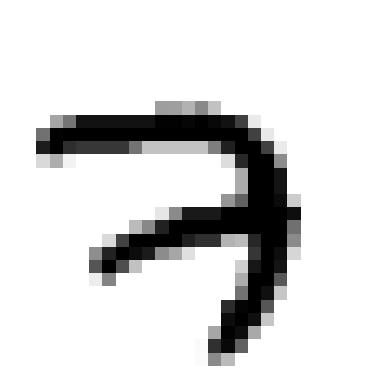

In [110]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

Os rótulos são os IDs de classe (representados como UINT8), de 0 a 9. Convenientemente, os IDs da classe correspondem aos dígitos representados nas imagens, para que não precisemos de uma matriz `Class_Names`:

In [111]:
y_train

array([7, 3, 4, ..., 5, 6, 8], dtype=uint8)

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [112]:
X_valid.shape

(5000, 28, 28)

In [113]:
X_test.shape

(10000, 28, 28)

Vamos dar uma olhada em uma amostra das imagens no conjunto de dados:

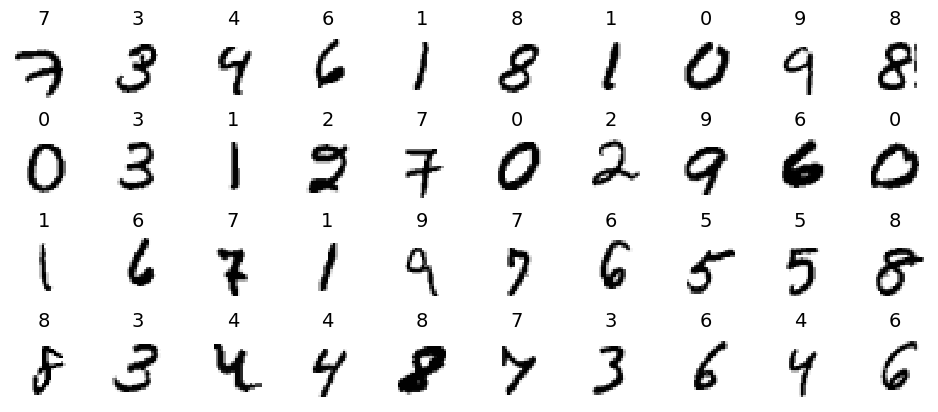

In [114]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(y_train[index])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Vamos construir uma rede densa simples e encontrar a taxa de aprendizado ideal.Precisamos de um retorno de chamada para aumentar a taxa de aprendizado a cada iteração.Ele também registrará a taxa de aprendizado e a perda em cada iteração:

In [115]:
K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

In [116]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [117]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

Começaremos com uma pequena taxa de aprendizado de 1e-3 e aumentaremos 0,5% em cada iteração:

In [118]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
expon_lr = ExponentialLearningRate(factor=1.005)

Agora vamos treinar o modelo por apenas 1 época:

In [119]:
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[expon_lr])

1719/1719 [==============================] - 4s 2ms/step - loss: nan - accuracy: 0.5785 - val_loss: nan - val_accuracy: 0.0958


Agora podemos plotar a perda em função da taxa de aprendizado:

Text(0, 0.5, 'Loss')

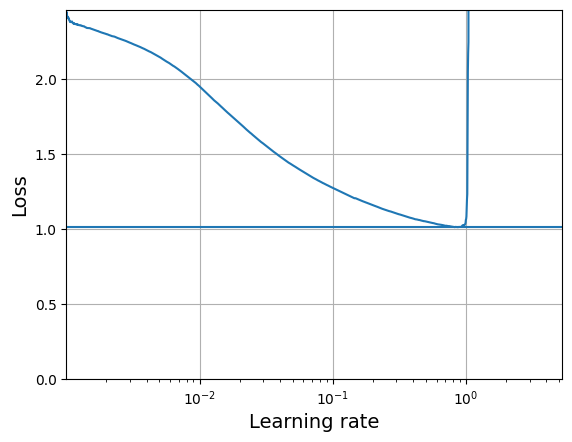

In [120]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

A perda começa a disparar de volta violentamente quando a taxa de aprendizagem ultrapassa 6e-1, então vamos tentar usar metade disso, em 3e-1:

In [121]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [122]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [123]:
optimizer = tf.keras.optimizers.SGD(learning_rate=3e-1)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [124]:
run_index = 1 # increment this at every run
run_logdir = Path() / "my_mnist_logs" / "run_{:03d}".format(run_index)
run_logdir

PosixPath('my_mnist_logs/run_001')

In [125]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_mnist_model", save_best_only=True)
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/100
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2319 - accuracy: 0.9273 - val_loss: 0.1104 - val_accuracy: 0.9660
Epoch 2/100
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0960 - accuracy: 0.9705 - val_loss: 0.1327 - val_accuracy: 0.9616
Epoch 3/100
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0652 - accuracy: 0.9797 - val_loss: 0.0717 - val_accuracy: 0.9780
Epoch 4/100
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0470 - accuracy: 0.9851 - val_loss: 0.0777 - val_accuracy: 0.9790
Epoch 5/100
1719/1719 [==============================] - 4s 3ms/step - loss: 0.0359 - accuracy: 0.9881 - val_loss: 0.0825 - val_accuracy: 0.9794
Epoch 6/100
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0298 - accuracy: 0.9903 - val_loss: 0.0804 - val_accuracy: 0.9790
Epoch 7/100
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0207 - accuracy: 0.9931 - val_loss: 0.0894 - val_ac

In [126]:
model = tf.keras.models.load_model("my_mnist_model") # rollback to best model
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0700 - accuracy: 0.9787


[0.06999247521162033, 0.9786999821662903]

Temos mais de 98% de precisão.Finalmente, vejamos as curvas de aprendizado usando o Tensorboard:

In [127]:
%tensorboard --logdir=./my_mnist_logs

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2024-01-18 20:15:12.358682: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-18 20:15:13.460740: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-18 20:15:13.460978: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-18 20:15:13.465529: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-18 20:15:14.243951: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-18 20:15: